# Video features Kermit and Waldorf&Statler
**Note**: this notebook includes video that visualise features applied on the Muppet show episodes directly. To activate those videos, change `show_video` to `True`. The kernel will probably crash if you want to exit the video, so you'd have to restart the notebook. They are not that important but nevertheless interesting to see the methods working directly frame-by-frame. 

In [8]:
import numpy as np
import pandas as pd
from scripts.load_data import check_and_load
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler
from scripts.sim1_extract_video_features import extract_dominant_colors, extract_contours, extract_glcm_features

In [9]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

In [10]:
# for testing
vid_path = "../ground_truth_data/Muppets-02-01-01.avi"
frame_path = '../ground_truth_data/frames/Muppets-02-01-01_frame37500.png' #frame with kermit
frame_path2 = '../ground_truth_data/frames/Muppets-03-04-03_frame38277.png' #frame with Waldorf&Statler
test_img = cv2.imread(frame_path)
test_img2 = cv2.imread(frame_path2)

In [11]:
#annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

## Dominant hue of the frame
We perform hue detection using k-means algorithm from the OpenCV library. To reduce inconsistencies in color detection, we convert RGB image read by OpenCV into HSV color space. Afterwards, we resize the image to reduce computational complexity. We found 100x100 pixel size to be sufficient and fast. 

The k-means algorithm minimizes variance within clusters and returns the cluster centers as the dominant colors. These colors are a vector of shape [num_colors, 3], which is used a feature for the model. We use 10 clusters for k-means and output 5 dominant colors by default to capture even smaller instances of Kermit, though this is a balancing act to achieve better results. The results of the dominant colors extraction depends on the random state a lot because centroids for k-means are initialised randomly. We managed to improve the color separation by using parameter `KMEANS_PP_CENTERS`, which uses a more sophisticated approach for center selection (as described in the paper by Arthur and Vassilvitskii https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf). 

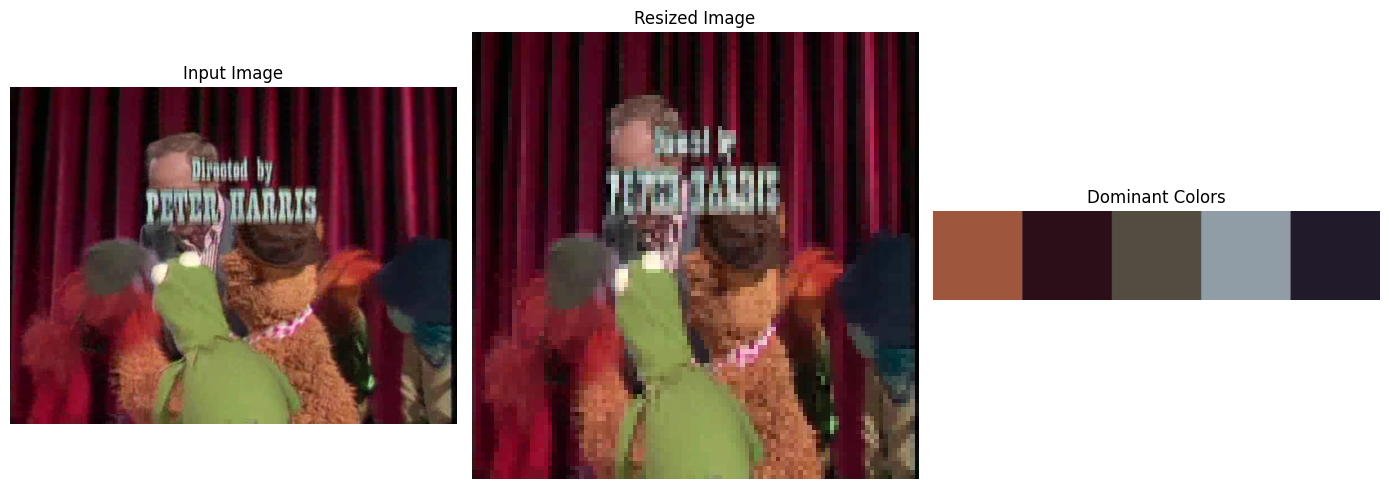

In [12]:
# extract dominant colors
test_dominant_colors = extract_dominant_colors(frame_path, 10, 5)
dominant_colors_bgr = cv2.cvtColor(np.uint8([test_dominant_colors]), cv2.COLOR_HSV2BGR)[0]

# Resize the input image to (100, 100)
resized_img = cv2.resize(test_img, (100, 100))

plt.figure(figsize=(14, 8))

# input  image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis("off")

# resized Image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis("off")

# dominant Colors
plt.subplot(1, 3, 3)
color_bar = np.zeros((50, len(dominant_colors_bgr) * 50, 3), dtype=np.uint8)
for i, color in enumerate(dominant_colors_bgr):
    color_bar[:, i * 50:(i + 1) * 50] = color

plt.imshow(cv2.cvtColor(color_bar, cv2.COLOR_BGR2RGB))
plt.title("Dominant Colors")
plt.axis("off")

plt.tight_layout()
plt.show()

<img src="pictures/statler_waldorf_colors.png" alt="SWcolors"/>

Code below allows to see the process dynamically in the video. 
Set `show_video = True` to run the code cell below for the visualisation. 
Note: the variable `n_clusters` must be changed within the loop for experiments, `n_colors` is not needed, it shows all colors by default (10 clusters = 10 colors).  

The code is slightly adapted from the top answer by u1234x1234 in this StackOverflow post https://stackoverflow.com/questions/73808864/get-most-dominant-colors-from-video-opencv-python. 

In [13]:
# Show video with color extraction
show_video = False

if show_video:
    cap = cv2.VideoCapture(vid_path)
    n_clusters = 10

    while True:
        status, image = cap.read()
        if not status:
            break

        # Convert the frame to HSV
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Resize the image for clustering and reshape it to a 2D array
        data = cv2.resize(hsv_image, (100, 100)).reshape(-1, 3)

        # Define criteria for k-means clustering
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)

        # Apply k-means clustering in HSV
        compactness, labels, centers = cv2.kmeans(
            data.astype(np.float32), 
            n_clusters, 
            None, 
            criteria, 
            10, 
            cv2.KMEANS_PP_CENTERS
        )

        # Convert cluster centers back to RGB
        centers_rgb = cv2.cvtColor(
            centers.reshape(1, -1, 3).astype(np.uint8), 
            cv2.COLOR_HSV2BGR
        ).reshape(-1, 3)

        # Get cluster sizes
        cluster_sizes = np.bincount(labels.flatten())

        # Create a palette to display the dominant colors
        palette = []
        for cluster_idx in np.argsort(-cluster_sizes):
            color_rgb = centers_rgb[cluster_idx]  # Get the RGB color for the cluster
            palette.append(
                np.full(
                    (image.shape[0], image.shape[1], 3), 
                    fill_value=color_rgb, 
                    dtype=np.uint8
                )
            )
        palette = np.hstack(palette)

        # Scale the palette for display
        sf = image.shape[1] / palette.shape[1]
        out = np.vstack([image, cv2.resize(palette, (0, 0), fx=sf, fy=sf)])

        # Display the output
        cv2.imshow("Dominant Colors (RGB)", out)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    cap.release()
    cv2.destroyAllWindows()
else:
    print("Set show_video to True to play the video presentation")


Set show_video to True to play the video presentation


## Edge detection (contours)
For edge detection, we are using `Canny` method from OpenCV with some preprocessing steps. The figure below summarizes part of our exploration process, excluding the parameter tuning, which we also did. 
We preprocess the frame by applying greyscale and bilateral blur. gaussian blur and median blur. We also resize the images to make it computationally feasible. Judging from the images, the shape is still somewhat recognizable in the 100x100 image, though of course not ideal .
We found bilateral filtering to give us the cleanest edges out of all methods we tried.

In [14]:
# Resize the image for comparison
resized_img = cv2.resize(test_img, (100, 100))

# Convert images to grayscale
gray_original = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
gray_resized = cv2.resize(gray_original, (100, 100))

# Apply Gaussian blur
gaussian_blur_original = cv2.GaussianBlur(gray_original, (7, 7), 0)
gaussian_blur_resized = cv2.GaussianBlur(gray_resized, (7, 7), 0)

# Apply Bilateral filter
bilateral_blur_original = cv2.bilateralFilter(gray_original, 7, 75, 75)
bilateral_blur_resized = cv2.bilateralFilter(gray_resized, 7, 75, 75)

# Apply Median blur
median_blur_original = cv2.medianBlur(gray_original, 7)
median_blur_resized = cv2.medianBlur(gray_resized, 7)

# Apply edge detection on blurred images
edges_gaussian_original = cv2.Canny(gaussian_blur_original, 75, 75)
edges_gaussian_resized = cv2.Canny(gaussian_blur_resized, 75, 75)

edges_bilateral_original = cv2.Canny(bilateral_blur_original, 75, 75)
edges_bilateral_resized = cv2.Canny(bilateral_blur_resized, 75, 75)

edges_median_original = cv2.Canny(median_blur_original, 75, 75)
edges_median_resized = cv2.Canny(median_blur_resized, 75, 75)

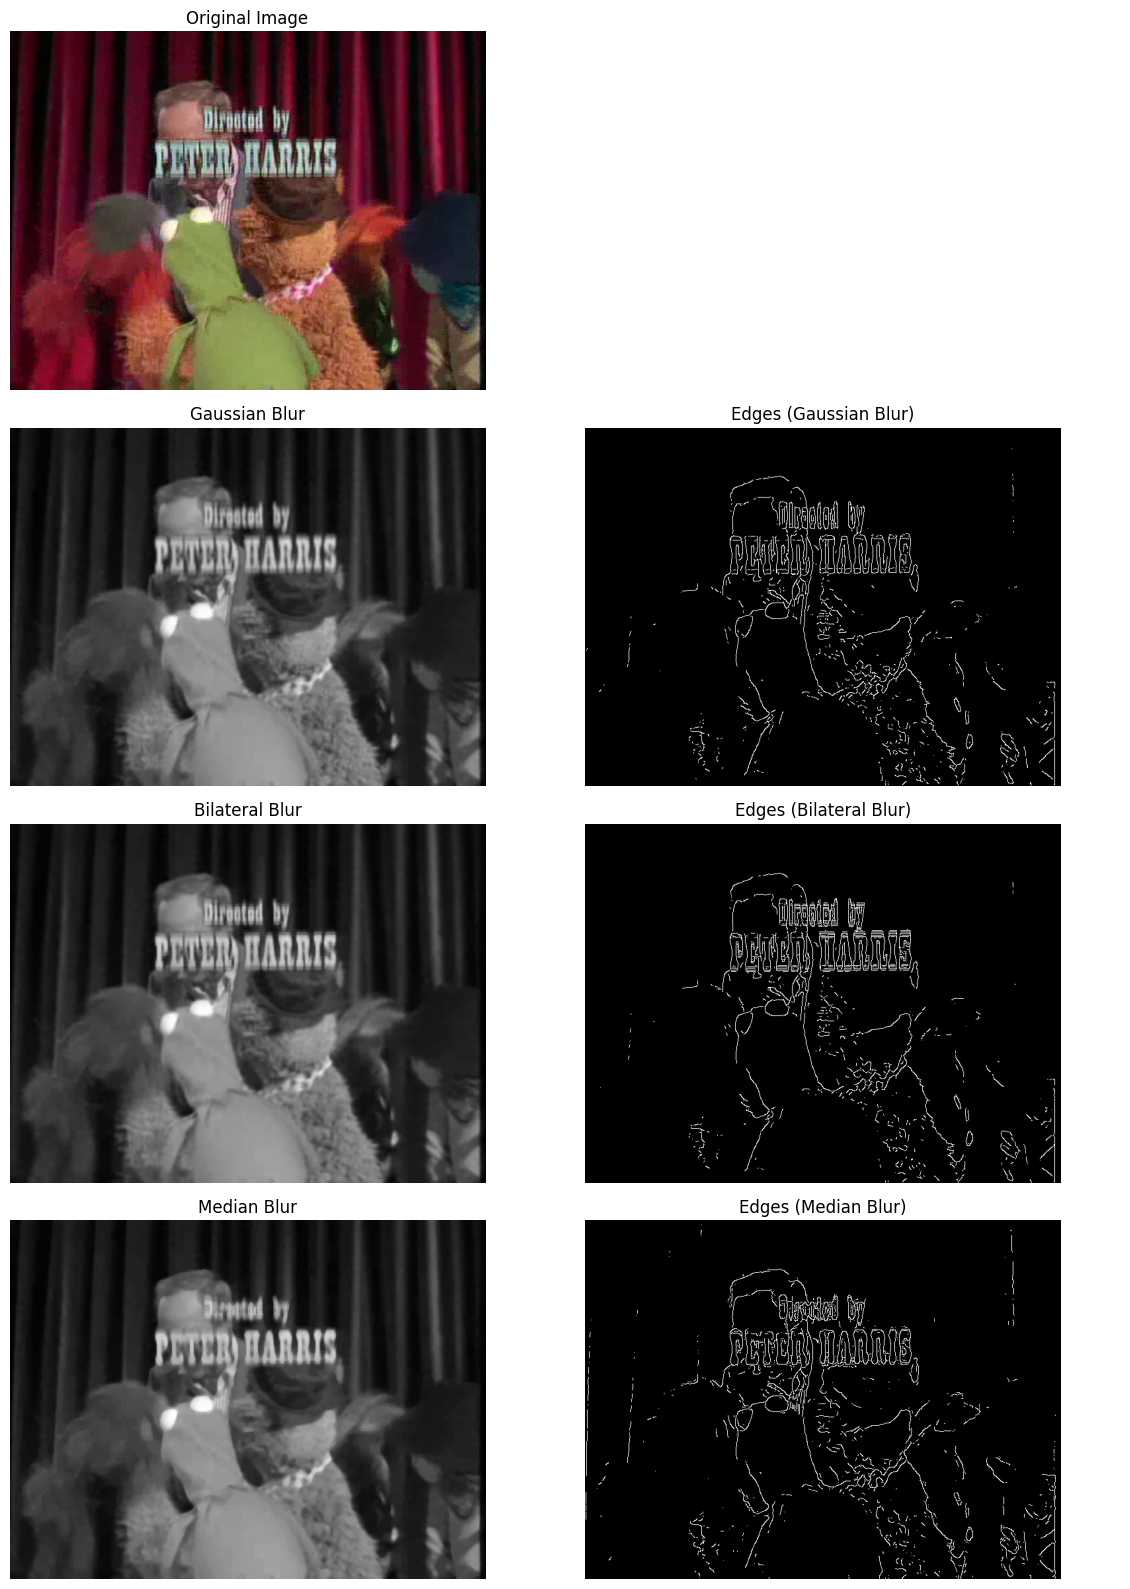

In [15]:
plt.figure(figsize=(12, 16))

# Row 1: Original Image / Blank
plt.subplot(4, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(4, 2, 2)
plt.axis("off")  # Leave blank

# Row 2: Gaussian Blur / Gaussian Edges
plt.subplot(4, 2, 3)
plt.imshow(gaussian_blur_original, cmap="gray")
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(4, 2, 4)
plt.imshow(edges_gaussian_original, cmap="gray")
plt.title("Edges (Gaussian Blur)")
plt.axis("off")

# Row 3: Bilateral Blur / Bilateral Edges
plt.subplot(4, 2, 5)
plt.imshow(bilateral_blur_original, cmap="gray")
plt.title("Bilateral Blur")
plt.axis("off")

plt.subplot(4, 2, 6)
plt.imshow(edges_bilateral_original, cmap="gray")
plt.title("Edges (Bilateral Blur)")
plt.axis("off")

# Row 4: Median Blur / Median Edges
plt.subplot(4, 2, 7)
plt.imshow(median_blur_original, cmap="gray")
plt.title("Median Blur")
plt.axis("off")

plt.subplot(4, 2, 8)
plt.imshow(edges_median_original, cmap="gray")
plt.title("Edges (Median Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()


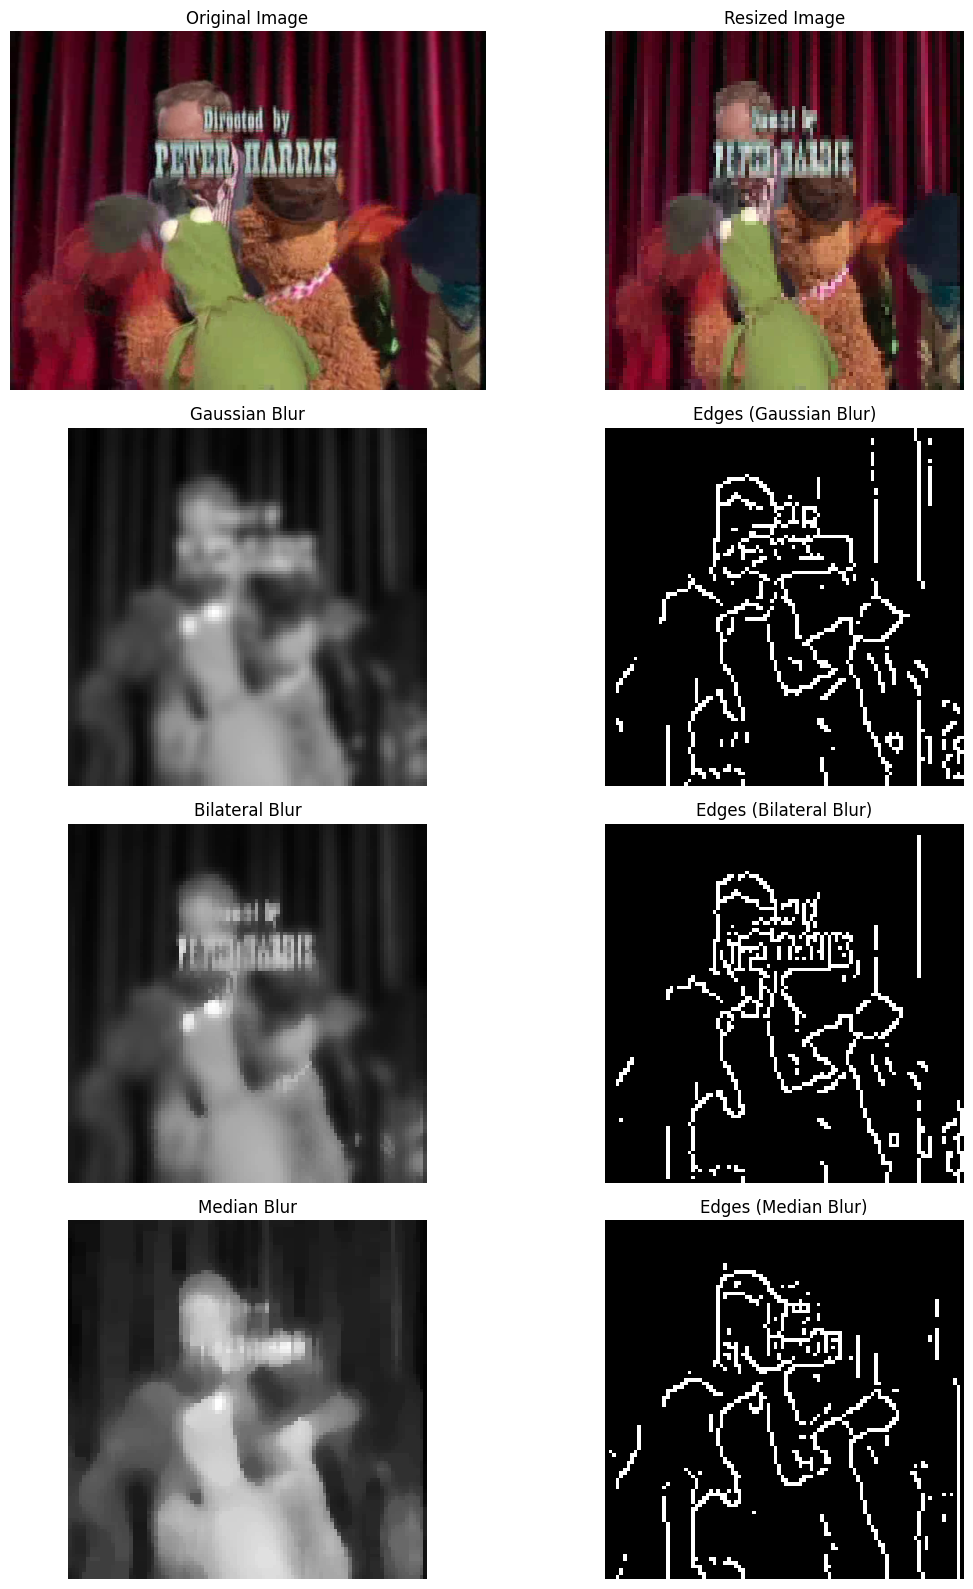

In [16]:
# Resize the image for comparison
resized_img = cv2.resize(test_img, (100, 100))

# Convert images to grayscale
gray_original = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
gray_resized = cv2.resize(gray_original, (100, 100))

# Apply Gaussian blur
gaussian_blur_original = cv2.GaussianBlur(gray_original, (7, 7), 0)
gaussian_blur_resized = cv2.GaussianBlur(gray_resized, (7, 7), 0)

# Apply Bilateral filter
bilateral_blur_original = cv2.bilateralFilter(gray_original, 7, 75, 75)
bilateral_blur_resized = cv2.bilateralFilter(gray_resized, 7, 75, 75)

# Apply Median blur
median_blur_original = cv2.medianBlur(gray_original, 7)
median_blur_resized = cv2.medianBlur(gray_resized, 7)

# Apply edge detection on blurred images
edges_gaussian_original = cv2.Canny(gaussian_blur_original, 75, 75)
edges_gaussian_resized = cv2.Canny(gaussian_blur_resized, 75, 75)

edges_bilateral_original = cv2.Canny(bilateral_blur_original, 75, 75)
edges_bilateral_resized = cv2.Canny(bilateral_blur_resized, 75, 75)

edges_median_original = cv2.Canny(median_blur_original, 75, 75)
edges_median_resized = cv2.Canny(median_blur_resized, 75, 75)

plt.figure(figsize=(12, 16))

# Row 1: Original Image / Resized Image
plt.subplot(4, 2, 1)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(4, 2, 2)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Resized Image")
plt.axis("off")

# Row 2: Gaussian Blur / Gaussian Edges
plt.subplot(4, 2, 3)
plt.imshow(gaussian_blur_resized, cmap="gray")
plt.title("Gaussian Blur")
plt.axis("off")

plt.subplot(4, 2, 4)
plt.imshow(edges_gaussian_resized, cmap="gray")
plt.title("Edges (Gaussian Blur)")
plt.axis("off")

# Row 3: Bilateral Blur / Bilateral Edges
plt.subplot(4, 2, 5)
plt.imshow(bilateral_blur_resized, cmap="gray")
plt.title("Bilateral Blur")
plt.axis("off")

plt.subplot(4, 2, 6)
plt.imshow(edges_bilateral_resized, cmap="gray")
plt.title("Edges (Bilateral Blur)")
plt.axis("off")

# Row 4: Median Blur / Median Edges
plt.subplot(4, 2, 7)
plt.imshow(median_blur_resized, cmap="gray")
plt.title("Median Blur")
plt.axis("off")

plt.subplot(4, 2, 8)
plt.imshow(edges_median_resized, cmap="gray")
plt.title("Edges (Median Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()


To save some space, we provide pictures how the same process works for two older gentlemen. The same functions as above were used to produce the images. 

<img src="pictures/statler_waldorf_original_contours.png" alt="SWcontorsoriginal" width="1000"/>

<img src="pictures/statler_waldorf_resized_contrours.png" alt="SWcontorsresized" width="1000"/>

We used the findings to write the function below for controur detection. 

In [17]:
show_video = False

def extract_contours_video(image, d=7):
    """
    update function for the video
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bilateral_blur = cv2.bilateralFilter(gray, d, 75, 75)
    edges = cv2.Canny(bilateral_blur, 75, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours

if show_video:
    cap = cv2.VideoCapture(vid_path)
    
    while True:
        status, image = cap.read()
        if not status:
            break

        # extract contours from the current frame
        contours = extract_contours_video(image)

        # draw contours on the original frame
        output_image = image.copy()
        cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)

        # display the frame with contours
        cv2.imshow("Contours", output_image)

        # press 'q' to exit the video loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
else:
    print("Set show_video to True to play the video presentation")

Set show_video to True to play the video presentation


## Texture (GLCM) 
Gray-Level Co-occurrence Matrix (GLCM) captures how pairs of neighboring pixels with specific values co-occur in an image, considering a particular distance and angle. These pixel pairs are used to capture the spatial patterns in the image, which can be indicative of the texture. Using `skimage` library we can conveniently extract the following features: contrast, correlation, energy and homogeneity. These features help with image segmentation and especially texture detection. Images must be grayscale for this method. 

GLCM Features:
Contrast: [0.7276858277833236, 0.9372825303724917, 0.0, 0.9999999999999998]
Correlation: [0.27247591880808386, 0.06268664608353447, 1.0, 0.0]
Energy: [0.19061281312490896, 0.02136838490221482, 0.9999999999999998, 0.0]
Homogeneity: [0.19288258557121307, 0.019908470646347265, 1.0, 0.0]


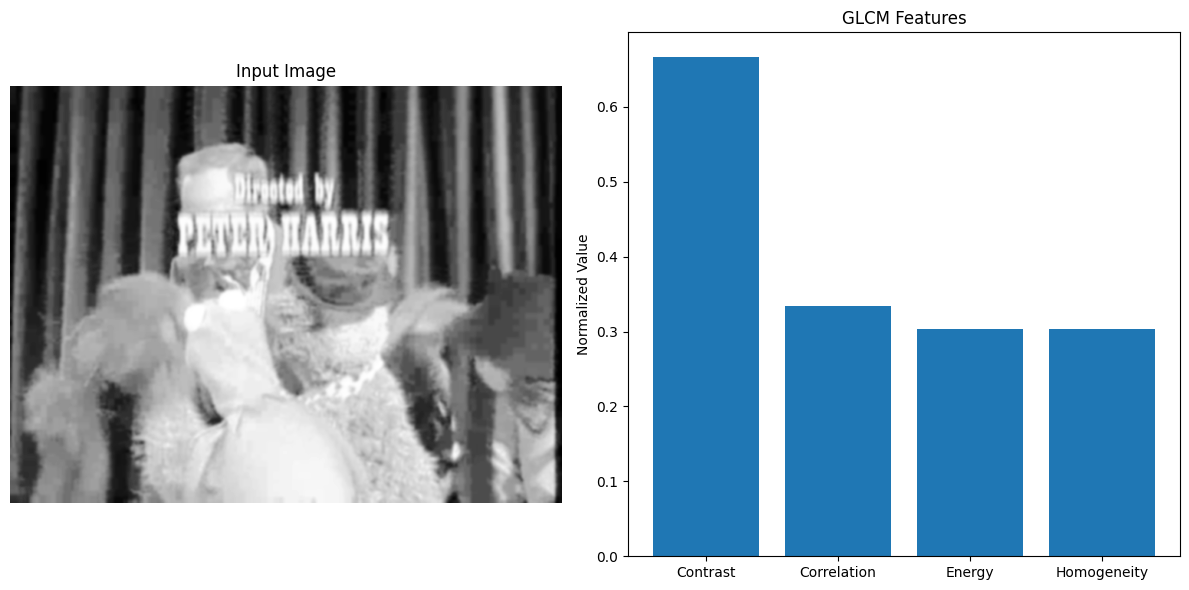

In [18]:
image_gray = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image 
image_gray = cv2.equalizeHist(image_gray) 
image_gray = cv2.GaussianBlur(image_gray, (7, 7), 0)  

# Extract GLCM features using the custom function
glcm_features = extract_glcm_features(frame_path, distance=1) 

print("GLCM Features:")
print(f"Contrast: {glcm_features['Contrast']}")
print(f"Correlation: {glcm_features['Correlation']}")
print(f"Energy: {glcm_features['Energy']}")
print(f"Homogeneity: {glcm_features['Homogeneity']}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].bar(['Contrast', 'Correlation', 'Energy', 'Homogeneity'],
            [np.mean(glcm_features['Contrast']),
             np.mean(glcm_features['Correlation']),
             np.mean(glcm_features['Energy']),
             np.mean(glcm_features['Homogeneity'])])
axes[1].set_title("GLCM Features")
axes[1].set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

<img src="pictures/statler_waldorf_glcm.png" alt="SWglcm"/>

# Kermit Classification

## Approach 1

## Approach 2

## Approach 3

## Evaluation

# Waldorf&Statler Classification

## Approach 1

## Approach 2

## Approach 3

## Evaluation

# Archive


Number of connected components (with Kermit): 489
Number of connected components (without Kermit): 332


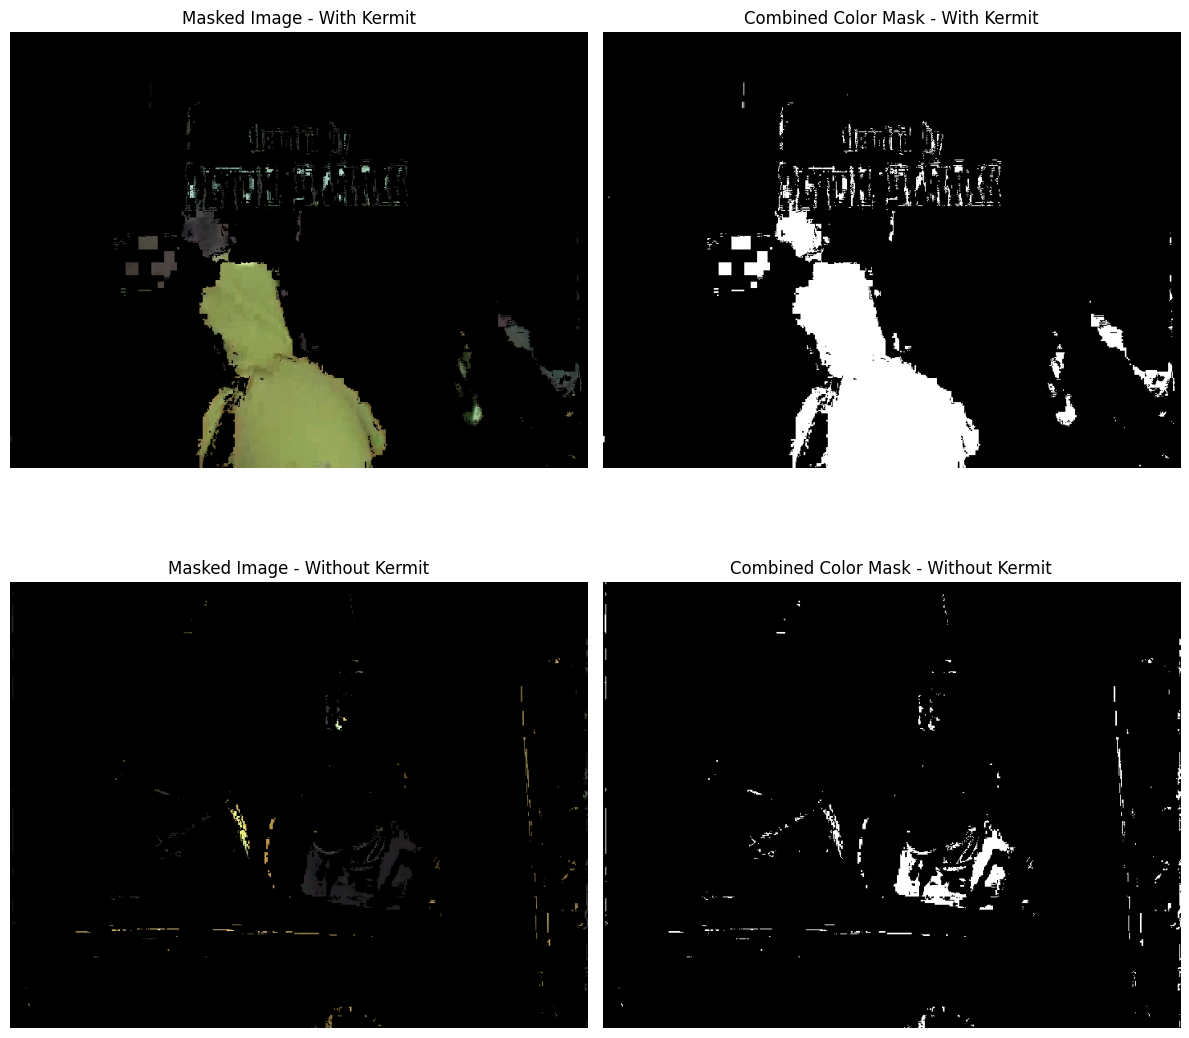

In [19]:
# Function to apply mask and get masked image
def get_masked_image(image):
    # Convert the image to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define multiple color ranges for Kermit (including variations of green, yellow, and dark shades)
    color_ranges = [
        (np.array([35, 40, 40]), np.array([85, 255, 255])),  # Green (flexible range)
        (np.array([20, 100, 100]), np.array([35, 255, 255])),  # Yellow
        (np.array([0, 0, 30]), np.array([180, 50, 80]))  # Dark shades
    ]

    # Create the combined mask by iterating over all color ranges
    combined_mask = np.zeros(image_hsv.shape[:2], dtype=np.uint8)
    for lower, upper in color_ranges:
        mask = cv2.inRange(image_hsv, lower, upper)
        combined_mask = cv2.bitwise_or(combined_mask, mask)

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=combined_mask)

    return masked_image, combined_mask

# Function to extract area and shape features (number of connected components)
def extract_area_and_shape_features(mask):
    # Find connected components in the mask
    num_components, labels = cv2.connectedComponents(mask)
    
    # The number of connected components is num_components - 1,
    # because the background is also considered as one component (label 0)
    return num_components - 1

test_img_with_kermit = test_img
test_img_without_kermit = test_img2

# Get masked images for both frames
masked_img_kermit, mask_kermit = get_masked_image(test_img_with_kermit)
masked_img_nokermit, mask_nokermit = get_masked_image(test_img_without_kermit)

# Extract the number of connected components for both masks
num_connected_components_kermit = extract_area_and_shape_features(mask_kermit)
num_connected_components_nokermit = extract_area_and_shape_features(mask_nokermit)

# Output the results
print(f"Number of connected components (with Kermit): {num_connected_components_kermit}")
print(f"Number of connected components (without Kermit): {num_connected_components_nokermit}")

# Display both Kermit and non-Kermit frames with the mask
plt.figure(figsize=(12, 12))

# Kermit frame
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(masked_img_kermit, cv2.COLOR_BGR2RGB))
plt.title("Masked Image - With Kermit")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(mask_kermit, cmap="gray")
plt.title("Combined Color Mask - With Kermit")
plt.axis("off")

# Non-Kermit frame
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(masked_img_nokermit, cv2.COLOR_BGR2RGB))
plt.title("Masked Image - Without Kermit")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(mask_nokermit, cmap="gray")
plt.title("Combined Color Mask - Without Kermit")
plt.axis("off")

plt.tight_layout()
plt.show()